In [252]:
# load in packages
library(data.table)
library(ggplot2)
library(bit64)
library(ggrepel)
library(tidyr)
library(caret)
library(ranger)
library(tidyverse)
library(e1071)
library(mgcv)
library(glmnet)
library(scales)
library(Matrix)
library(Hmisc)
library(MASS)
library(lubridate)
library(binom)
library(stargazer)
library(rtweet)
library(tidytext)
# so i don't have to remember repr.plot.width every time
pltsize <- function(w,h){
    options(repr.plot.width = w, repr.plot.height =h)
}

# util function for reading in files from twitter_dm
read_simple_user_info <- function(inFile){
  
  r = readBin(inFile, raw(), file.info(inFile)$size)
  r[r==as.raw(0)] = as.raw(0x20)
  tfile = tempfile(fileext=".txt")
  writeBin(r, tfile)
  rm(r)
  inFile = tfile
  
  return(fread(inFile, sep="\t",col.names =c("uid",
                                             'name',
                                             "screen_name",
                                             'url',
                                             'protected',
                                             'location',
                                             'description',
                                             "followers_count",
                                             "friends_count",
                                             "created_at",
                                             "utc_offset",
                                             'time_zone',
                                             "statuses_count",
                                             "lang",
                                             "status_created_at",
                                             'status_coordinates',
                                             "status_lang",
                                             "profile_image_url_https","verified"), colClasses = c("V1"="character")))
}

# Read in all data

In [3]:
panel <- fread("/data/kenny/panel_demographics.csv")
panel_data <- panel[party %in% c("Republican", "Democrat"), .(twProfileID,party)]

In [4]:
# Get the data from the observed replies of the simulated accounts (realtime and historical)
trump_panel <- fread("/home/zijianan/csv_update2/dt_panel_new_top_10.csv")
biden_panel <- fread("/home/zijianan/csv_update2/jb_panel_new_top_10.csv")
trump_realtime <- fread("/home/zijianan/csv_update2/dt_real_time_top_10.csv")
biden_realtime <- fread("/home/zijianan/csv_update2/jb_real_time_top_10.csv")

In [5]:
trump_panel$sentby <- "Trump"
trump_panel$sample <- "Complete"
trump_panel$script_date <- trump_panel$scrap_date
trump_panel$scrap_date <- NULL
biden_panel$sentby <- "Biden"
biden_panel$sample <- "Complete"

reply_data <- rbind(trump_panel, biden_panel)
reply_data <- reply_data[!username %in% c("JoeBiden","realDonaldTrump") ]

# toss the outliers that have > 10 replies
reply_data <- merge(reply_data, 
                    reply_data[, .N, by = .(sentby,tid,account)][N <11,-"N",with=F],
                    by=c("sentby","tid","account"))

# also some odd cases where tweet was collected twice
reply_data <- reply_data[ ! tid %in% reply_data[,length(unique(script_date)), by=.(tid,sentby,account)][V1 > 1]$tid]
reply_data <- reply_data[!duplicated(reply_data[,.(tid,account,sentby,url)])]

trump_realtime$sentby <- "Trump"
trump_realtime$sample <- paste("Real-time", trump_realtime$collection_group)
biden_realtime$sentby <- "Biden"
biden_realtime$sample <- paste("Real-time", biden_realtime$collection_group)
trump_realtime$collection_group <- NULL
biden_realtime$collection_group <- NULL
reply_data <- rbind(reply_data,
                    rbind(trump_realtime,biden_realtime),
                    fill=T)

In [6]:
# get the ID of the reply, just pull it from the URL to the tweet
reply_data[, reply_tid := as.integer64(gsub("https://twitter.com/.+/status/", "",url))]

In [7]:
# Who do the fake accounts follow? 
# Boring note: Originally from pickle files elsewhere on server, stripped into CSV for easier processing
friends_of_fake_accts <- fread("friends_of_fake_accts.tsv")
setnames(friends_of_fake_accts, c("account","id"))
friends_of_fake_accts$id <- as.character(friends_of_fake_accts$id)

setnames(friends_of_fake_accts, "id","userid")


In [8]:
# For studying whether or not panel was heard
panel_member_attributes <- fread("active_nonactive_user_categorization2.csv")
panel_member_attributes$uid <- as.character(panel_member_attributes$uid)

In [421]:
panel_member_attributes[, .N, by=.(sentby,is_active_reply)]

sentby,is_active_reply,N
Trump,active,1794
Trump,non_active,88485
Biden,active,1320
Biden,non_active,18277


In [9]:
reply_data <- merge(reply_data, panel_member_attributes, 
                    by.x=c("userid","sentby"),
                    by.y=c("uid","sentby"),
                    all.x=T)

In [10]:
# Cleaner account names
reply_data[, clean_acct := factor(account, levels=rev(c("arep","nrep","adem","ndem","fot","nfot")),
                          labels=rev(c("Active Republican",
                                  "Non-active Republican",
                                  "Active Democrat",
                                  "Non-active Democrat",
                                  "Control: Only Follow Trump",
                                  "Control: Follow No-one")))]

In [78]:
# pltsize(9,7)
# # Take a look at the distribution of number of tweets per account/sample
# ggplot(reply_data[, .N, by = .(sentby,tid,account,sample)], 
#        aes(N,fill=sentby)) + geom_histogram(binwidth=1) + facet_grid(sample~account,scales="free_y") + 
# xlab("Number of Tweets per tweet/simulated account") 


In [288]:
reply_data[,length(unique(tid)), by=.(sample,sentby)]

sample,sentby,V1
Complete,Trump,9713
Complete,Biden,2556
Real-time 0,Trump,120
Real-time 20,Trump,120
Real-time 30,Trump,120
Real-time 10,Trump,120
Real-time 40,Trump,120
Real-time 50,Trump,120
Real-time 10,Biden,80
Real-time 20,Biden,80


In [15]:
# Mean observed per tweet per account/collection period
reply_data[, .N, by = .(sentby,tid,account,sample)][, as.list(smean.cl.boot(N)), by=.(sentby,sample)]

sentby,sample,Mean,Lower,Upper
Trump,Complete,8.587376,8.572495,8.601421
Biden,Complete,9.838581,9.828119,9.848120
Trump,Real-time 0,7.918056,7.708299,8.127813
Trump,Real-time 20,9.084722,8.954167,9.220833
Trump,Real-time 30,8.352778,8.184687,8.516667
Trump,Real-time 10,8.609722,8.462500,8.769444
Trump,Real-time 40,9.170833,9.056944,9.281979
Trump,Real-time 50,8.195833,8.023542,8.383368
Biden,Real-time 10,7.395833,7.151927,7.608333
Biden,Real-time 20,8.281250,8.085365,8.487500


In [13]:
# Percent of replies sent by since-suspended users
reply_data[, sum(userid=="unknow")/.N, by = .(sentby,sample)][order(-V1)]

sentby,sample,V1
Biden,Real-time 10,0.218591549
Biden,Real-time 0,0.210767065
Biden,Real-time 20,0.210314465
Biden,Real-time 40,0.200422932
Biden,Real-time 50,0.195882921
Biden,Real-time 30,0.195797517
Trump,Real-time 0,0.140501666
Trump,Real-time 10,0.123890950
Trump,Real-time 20,0.118330530
Trump,Real-time 30,0.107416029


In [237]:
reply_data[, length(unique(tid)), by = .(sample,sentby)]

sample,sentby,V1
Complete,Trump,9713
Complete,Biden,2556
Real-time 0,Trump,120
Real-time 20,Trump,120
Real-time 30,Trump,120
Real-time 10,Trump,120
Real-time 40,Trump,120
Real-time 50,Trump,120
Real-time 10,Biden,80
Real-time 20,Biden,80


In [305]:
reply_data[, is_panel := !is.na(is_active_reply)]

In [306]:
reply_data[, as.list(smean.cl.normal(likes)), by = is_panel]

is_panel,Mean,Lower,Upper
FALSE,393.9401,389.5466,398.3336
TRUE,1161.3576,1121.9355,1200.7798


In [309]:
reply_data[, as.list(smean.cl.normal(retweets)), by = .(is_panel, sample)][order(sample,is_panel)]

is_panel,sample,Mean,Lower,Upper
FALSE,Complete,61.165320,60.3155505,62.015090
TRUE,Complete,203.748686,192.8836996,214.613673
FALSE,Real-time 0,1.411236,0.5643748,2.258097
TRUE,Real-time 0,1.363636,0.3270437,2.400229
FALSE,Real-time 10,10.737305,9.5865496,11.888061
TRUE,Real-time 10,29.417722,22.1027208,36.732722
FALSE,Real-time 20,18.507265,17.1260963,19.888434
TRUE,Real-time 20,58.053419,49.8802104,66.226627
FALSE,Real-time 30,23.491340,21.8684542,25.114226
TRUE,Real-time 30,82.775726,70.1952582,95.356193


In [304]:
reply_data[, sum(is_panel)/.N, by=sentby]

sentby,V1
Trump,0.9696216
Biden,0.9709649


# Top Repliers

In [ ]:
mg <- merge(reply_data[, list(n_seen = length(unique(tid))), by =.(clean_acct, sample,username,sentby)],
            reply_data[, list(total=length(unique(tid))), by=.(clean_acct,sample,sentby)])
mg[, perc := n_seen/total]

In [345]:

top <- merge(mg,
             mg[,mean(perc),by=.(username,sample,sentby)][, .SD[order(-V1)][1:10], by=.(sample,sentby)],
             by=c("username","sample","sentby"))

In [392]:
create_token(
app = "u1",
"APP_TOKEN",
"APP_SECRET",
access_token = "ACCESS_TOKEN",
access_secret = "ACCESS_SECRET",
set_renv = TRUE
)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


<Token>
<oauth_endpoint>
 request:   https://api.twitter.com/oauth/request_token
 authorize: https://api.twitter.com/oauth/authenticate
 access:    https://api.twitter.com/oauth/access_token
<oauth_app> u1
  key:    qs1Zr3JtxtVu32ySYa4bpsUXU
  secret: <hidden>
<credentials> oauth_token, oauth_token_secret
---

In [393]:
u <- lookup_users(unique(top$username))

Registered S3 method overwritten by 'openssl':
  method      from
  print.bytes Rcpp


In [399]:
u <- data.table(u)

In [402]:
summary(u[screen_name %in% top[sample %in% c("Complete","Real-time 10","Real-time 50")]$username,
              .(screen_name,followers_count)]$followers_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      4    8041   35848  162087  296938  765671 

In [413]:
top_plt<- merge(top[sample %in% c("Complete","Real-time 10","Real-time 50")],
             u[followers_count > 5000],
             by.x="username",
             by.y="screen_name")

In [420]:
unique(top_plt[sentby=="Trump",.(username,description,followers_count,statuses_count)])

username,description,followers_count,statuses_count
ChrisJZullo,Rockefeller Republican preaching from left with a right. Agnostic Theist. Regulatory Capitalist. On lifelong quest to prove knowledge more important than money,147450,53093
DeepStateExpose,Jeremy Stone | Bestselling Author | Conservative | Trumper | RT'D by POTUS 10X | Q'd 2X | Conspiracy Realist | Search 'Jeremy Stone Books' @ Amazon,348013,55172
DonnyTheMessiah,Survivor of Windmill noise cancer. Helped capture the airports in the Revolutionary war. Currently using the unlimited powers of Article II. WHITE POWER!,10102,16241
HKrassenstein,"Wife of a Krassenstein brother, mother of two awesome kids. :) Email: krassensteinmail@protonmail.com Husband's FB: https://t.co/Xxw3zH00D1",128697,9210
JeffreyGuterman,#BidenHarris #OTD #JFKGuterman #BaseballGuterman #MusicGuterman #SportsGuterman #ReflectionsGuterman #GutermanDreams #StratOMaticGuterman #BlackLivesMatter,346386,226678
LindaSuhler,I support PRESIDENT Trump! America First Christian supports Family~Constitution~Capitalism~NRA~ Military~Police~Israel~ #Trump2020 *My views are solely mine*,418843,444757
Lrihendry,Here for @realDonaldTrump•Proudly RTed by President Trump•purveyor of truth •Views are my own #AmericaFirst #TRUMP2020 #KAG 🚫NO FF TRAINS,364911,348109
MatthewJshow,Matthew J Conway is a proud supporter of the America First Agenda. Retweeted by President Trump. Host of the MatthewJshow. Available on https://t.co/N76zO7H6zn,37355,118277
ScottPresler,I helped defeat Hillary & organized the Baltimore cleanup. Republicans need 18 seats to flip the House. Focus on voter registration. https://t.co/SRaEZoa2Vi,765671,79694
TWIT_ANTHONY,I love President Trump. *Sometimes sarcastically* Memoir coming. *Opinions are my own*,14557,11179


In [497]:
pltsize(11,4)
theme_set(theme_minimal(14))
p <- ggplot(top_plt[sentby=="Trump" & username != "LindaSuhler"], aes(reorder_within(username,V1,sample), perc,fill=clean_acct))+
geom_bar(stat='identity',position=position_dodge()) +
scale_x_reordered("") +
coord_flip()+
facet_wrap(~sample,scales="free_y",nrow=1) + 
guides(fill=guide_legend(nrow=6,byrow=TRUE)) +
scale_y_continuous("Percent of Tweets in which User Appeared\nfor Simulated Account",labels=percent) +
scale_fill_manual("Simulated\nAccount",values=c("black","grey","darkblue","blue","red","darkred"))
#p
ggsave("users.pdf",p,h=4,w=11)

# Was the panel heard?

In [727]:
m <- reply_data[,list(n_panel=sum(!is.na(is_active_reply)), total=.N), by=.(sentby,tid,clean_acct,sample)]

In [728]:
binom.agresti.coull(sum(m$n_panel > 0), nrow(m))

method,x,n,mean,lower,upper
agresti-coull,17349,76344,0.2272477,0.2242889,0.230234


In [729]:
head(friends_of_fake_accts)

account,userid
nrep,15027207
nrep,15012486
nrep,1500129642
nrep,1493267851
nrep,14880616
nrep,14844867


In [730]:
friends_of_fake_accts[userid %in% panel_member_attributes$uid]

account,userid
nrep,931286316
adem,338608917
adem,15446531
adem,594175899
adem,759481842814726144
adem,24431892
adem,17642747
adem,18382184
adem,186667011
adem,32671625


In [731]:
aj <- data.table(anti_join(reply_data,friends_of_fake_accts[userid %in% panel_member_attributes$uid], 
                           by.x=c("account","userid")))
m2 <- aj[,list(n_panel=sum(!is.na(is_active_reply)), total=.N), by=.(tid,clean_acct,sample)]
binom.agresti.coull(sum(m2$n_panel > 0), nrow(m2))

Joining, by = c("userid", "account")


method,x,n,mean,lower,upper
agresti-coull,13894,76343,0.1819944,0.1792734,0.1847474


In [732]:
m[, out := n_panel > 0]

In [735]:
stargazer(glm(out ~clean_acct+sentby*sample,data=m,family=binomial(link="logit")))


% Table created by stargazer v.5.2.2 by Marek Hlavac, Harvard University. E-mail: hlavac at fas.harvard.edu
% Date and time: Wed, Sep 16, 2020 - 02:05:15 AM
\begin{table}[!htbp] \centering 
  \caption{} 
  \label{} 
\begin{tabular}{@{\extracolsep{5pt}}lc} 
\\[-1.8ex]\hline 
\hline \\[-1.8ex] 
 & \multicolumn{1}{c}{\textit{Dependent variable:}} \\ 
\cline{2-2} 
\\[-1.8ex] & out \\ 
\hline \\[-1.8ex] 
 clean\_acctControl: Only Follow Trump & 0.015 \\ 
  & (0.031) \\ 
  & \\ 
 clean\_acctNon-active Democrat & $-$0.001 \\ 
  & (0.031) \\ 
  & \\ 
 clean\_acctActive Democrat & 0.169$^{***}$ \\ 
  & (0.031) \\ 
  & \\ 
 clean\_acctNon-active Republican & 0.379$^{***}$ \\ 
  & (0.030) \\ 
  & \\ 
 clean\_acctActive Republican & 0.326$^{***}$ \\ 
  & (0.030) \\ 
  & \\ 
 sentbyTrump & 0.065$^{***}$ \\ 
  & (0.022) \\ 
  & \\ 
 sampleReal-time 0 & $-$1.122$^{***}$ \\ 
  & (0.166) \\ 
  & \\ 
 sampleReal-time 10 & 0.006 \\ 
  & (0.112) \\ 
  & \\ 
 sampleReal-time 20 & 0.434$^{***}$ \\ 
  & (0.

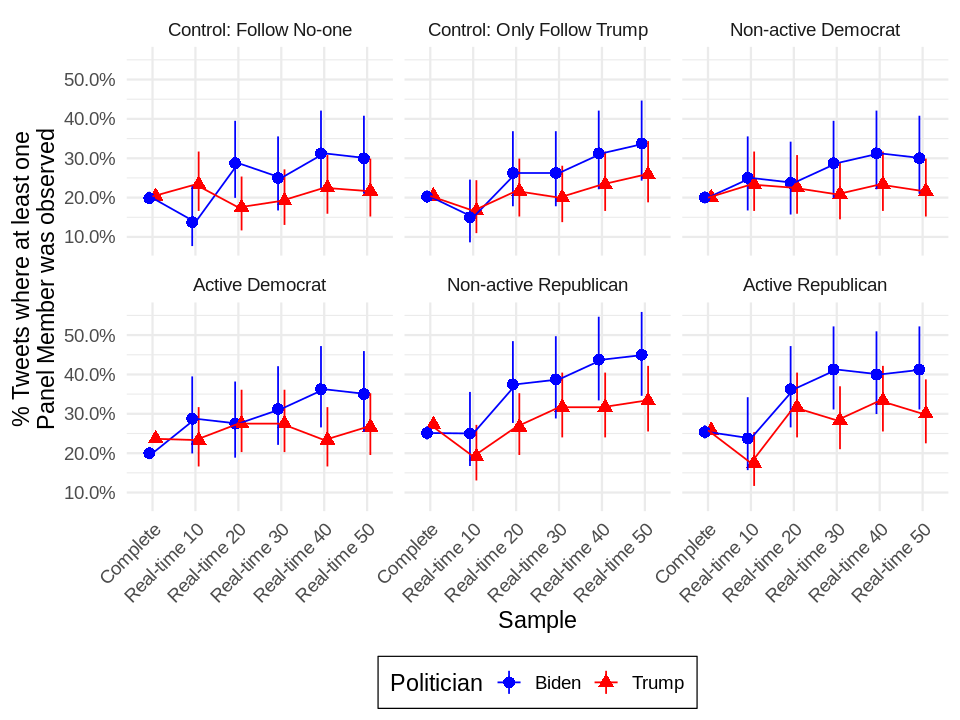

In [311]:
# Percent of tweets were att least one panel member was observed
z <-m[, binom.agresti.coull(sum(n_panel > 0), .N), by=.(sentby,clean_acct,sample)]


pz <- ggplot(z[sample != "Real-time 0"], aes(sample,mean,ymin=lower,ymax=upper,color=sentby,shape=sentby,group=sentby)) + 
    geom_point(position=position_dodge(.3),size=3)  +
    geom_linerange(position=position_dodge(.3)) +
    facet_wrap(~clean_acct,nrow=2) +
    scale_y_continuous("% Tweets where at least one\nPanel Member was observed",
                       labels=percent) + xlab("Sample") +
    theme(legend.box.background = element_rect(colour = "black",fill="white"),
          axis.text.x=element_text(angle=45,hjust=1),
          legend.position='bottom') + 
    scale_color_manual("Politician",values=c("blue","red")) +
    scale_shape_discrete("Politician") + geom_line() +
    guides(color=guide_legend(nrow=1,byrow=TRUE),shape=guide_legend(nrow=1,byrow=TRUE))
ggsave("panel_heard.pdf", w=8,h=6)
pltsize(8,6)
pz

# Partisanship Analysis

In [20]:
# Users to who they're following
net <- fread("all_trimmed_net.csv")
net <- net[V1 != "unknow"]

In [21]:
repliers <- data.table(V1=unique(as.integer64(reply_data$userid)))
repliers <- repliers[!is.na(V1)]

In [22]:
panel_data$uid <- as.integer64(panel_data$twProfileID)
net$V1 <- as.integer64(net$V1)
net$V2 <- as.integer64(net$V2)

In [23]:
# Merge with panel, run regression only on Republicans and Democrats
# Create the two networks
net_panel <- merge(net, panel_data, by.x="V1", by.y="uid")
net_repliers <- merge(net, repliers, by="V1")

In [24]:
following_db <- merge(net_panel[, .N, by =V2],
                      net_repliers[,.N, by = V2], by="V2")
following_db <- following_db[N.x > 100 & N.y > 25]
following_db[, fol_mat_ind := 1:nrow(following_db)]

In [25]:
nrow(following_db)

[1] 18609

In [26]:
# Subset to study only those who follow accounts in the regression model
panel_db <- net_panel[ V2 %in% following_db$V2, .N, by = V1][N >=5 ]
nrow(panel_db)
panel_db[, mat_ind := 1:nrow(panel_db)]

replier_db <- net_repliers[ V2 %in% following_db$V2, .N, by = V1][N >=5 ]
nrow(replier_db)
replier_db[, mat_ind := 1:nrow(replier_db)]

[1] 502956

[1] 99156

In [27]:
# Create final networks
net_panel <- merge(merge(net_panel, panel_db, by="V1"), following_db, by = "V2")
net_repliers <- merge(merge(net_repliers, replier_db, by="V1"), following_db, by = "V2")


In [28]:
panel_data <- merge(panel_data, panel_db, by.x="uid",by.y="V1")
panel_data <- panel_data[order(mat_ind)]

In [29]:
nrow(panel_data)

[1] 502956

In [30]:
# Run regression model to predict partisanship
mat_panel <- sparseMatrix(i = net_panel$mat_ind,
                          j = net_panel$fol_mat_ind,
                          x = rep(1, nrow(net_panel)))

train_index <- sample(1:nrow(panel_data), 0.9 * nrow(panel_data))
train_index <- sort(train_index)
train <- mat_panel[train_index, ]
test <- mat_panel[-train_index, ]


mod <- cv.glmnet(x=train,
              y=panel_data[mat_ind %in% train_index]$party,
              family="binomial")

In [38]:
# Evaluate regression model
preds <- predict.cv.glmnet(mod,
                           newx=test,
                           s=mod$lambda.1se,
                           type="response")

pred_dat <- data.table(true=panel_data[!(mat_ind %in% train_index)]$party, 
                       pred=preds[,1])
pred_dat[, true_int := ifelse(true == "Democrat",0,1)]
pred_dat[ ,pv := "Democrat"]
sum(pred_dat$true==pred_dat$pv)/nrow(pred_dat)
pred_dat[, p := ifelse(pred  < .5, "Democrat","Republican")]
sum(pred_dat$true==pred_dat$p)/nrow(pred_dat)

[1] 0.6332909

[1] 0.7979362

In [39]:
# Check out coefficients of the regression model 
coefficients <- coef(mod, s=mod$lambda.1se)
coefficients <- data.frame(name=rownames(coefficients),s0=as.vector(coefficients))
coefficients <- coefficients[abs(coefficients$s0) >0,]
coefficients <- data.table(coefficients)
coefficients <- coefficients[name != "(Intercept)"]
coefficients[, fol_mat_ind := as.integer(sub("V","",name))]

nrow(coefficients)
nrow(merge(coefficients,following_db, by="fol_mat_ind"))

coefficients <- merge(coefficients,following_db, by="fol_mat_ind")


[1] 3107

[1] 3107

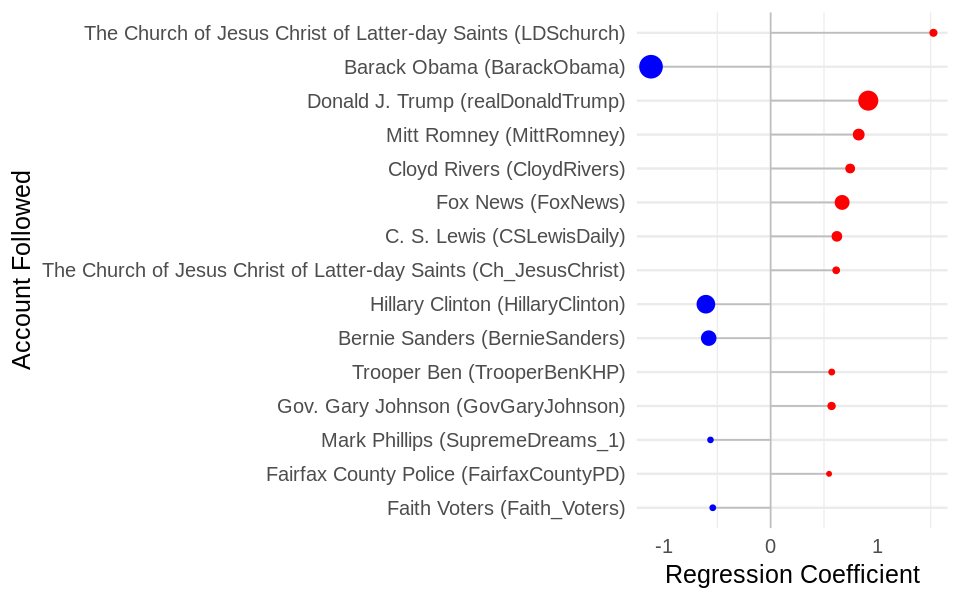

In [428]:
# Plot the top coefficients
d <- coefficients[order(-abs(s0))][1:20]
write.table(d$V2, "./replid.txt",row.names=F,quote=F,col.names=F)
theme_set(theme_minimal(15))
# ok go get the info about these people using twitter_dm (http://github.com/kennyjoseph/twitter_dm)
# python ~/twitter_dm/examples/collect_basic_user_profile_info.py  twitter_creds/cred1.txt replid.txt top_coef
d$V2 <- as.character(d$V2)
k <- read_simple_user_info("./top_coef/0_user_info.txt")
d <- merge(d,k, by.x="V2",by.y="uid")
d <- d[order(-abs(s0))][1:15]
d$screen_name <- factor(paste0(d$name.y, " (",d$screen_name,")") ,
                        levels=paste0(d[order(abs(s0))]$name.y, " (",d[order(abs(s0))]$screen_name,")"))
pl <- ggplot(d, aes(x=screen_name, y=s0, color=s0 > 0)) +
  geom_segment( aes(x=screen_name, xend=screen_name, y=0, yend=s0), color="grey") +
  geom_point(aes(size=N.x)) +
  theme(
    panel.grid.major.x = element_blank(),
    panel.border = element_blank(),
    axis.ticks.x = element_blank()
  ) +
  xlab("Account Followed") + scale_size_continuous(guide=F) + 
  ylab("Regression Coefficient") + coord_flip() + scale_color_manual(guide=F,values=c("blue","red")) +
  geom_hline(yintercept=0,color='grey')
ggsave("coef.pdf", pl, h=4,w=8)
pltsize(8,5)
pl

In [429]:
1/(1+exp(.03))

[1] 0.4925006

In [44]:
# Finally, apply the model to the repliers
net_repliers <- merge(net_repliers, coefficients[,.(fol_mat_ind, s0)], by="fol_mat_ind")


In [623]:
repliers_partisanship <- net_repliers[, list(n=.N,val=1/(1+exp(-sum(s0)))), by= V1]


In [624]:
cpy = copy(friends_of_fake_accts)
cpy$userid <- as.integer64(cpy$userid)
merge(cpy,coefficients, by.x="userid", by.y="V2")[, sum(s0), by=account]

account,V1
nrep,8.6577420
adem,-3.1326823
arep,0.6758028
ndem,-4.5171949


# Source Bias

In [625]:

create_bias_df <- function(data){
    # create subsets of replies that were accounts followed by / not followed by the simulated accounts (or all)
    k1 <- data.table(anti_join(data,friends_of_fake_accts, by=c("account","userid")))
    k1$t <- "Only Accounts\nNot Followed By\nSimulated Account"
    k2 <- data.table(merge(data, friends_of_fake_accts, by=c("account","userid")))
    k2$t <- "Only Accounts\nFollowed By\nSimulated Account"
    k3 <- data
    k3$t <- "All Accounts"
    k <- rbind(k1,k2,k3)
    k$userid <- as.integer64(k$userid)
    return(k)
}

gen_bias_plot <- function(data,hline_spt){
    theme_set(theme_minimal(20))
    pz <- ggplot(data[sample != "Real-time 0"], 
                 aes(clean_acct, Mean, ymin=Lower,ymax=Upper,color=t,shape=t))+
    geom_point(size=3) + geom_linerange() + coord_flip() +
    scale_color_manual("Replies from...", values=c("Green","Orange","Black")) + 
    scale_shape_discrete("Replies from...") +
    xlab("Simulated Account") +

    guides(color=guide_legend(keyheigh=.4, default.unit="in")) +
    facet_grid(sample~sentby) + geom_hline(yintercept =hline_spt, color = 'black', linetype='dashed')
}

# What percentage of tweets seen overall, in any sample, are from accounts not followed by users?
nrow(anti_join(reply_data,
               friends_of_fake_accts, by.x=c("account","userid")))/nrow(reply_data)

Joining, by = c("userid", "account")


[1] 0.9412122

In [626]:
mg <- merge(data.table(anti_join(reply_data,friends_of_fake_accts, by.x=c("account","userid")))[,.N, by=clean_acct],
      reply_data[,.N, by=clean_acct], by="clean_acct")
mg[, perc := N.x/N.y]
mg

Joining, by = c("userid", "account")


clean_acct,N.x,N.y,perc
Control: Follow No-one,111835,111835,1.0000000
Control: Only Follow Trump,112599,112599,1.0000000
Non-active Democrat,107804,117270,0.9192803
Active Democrat,96686,107105,0.9027216
Non-active Republican,103903,111034,0.9357764
Active Republican,98492,110908,0.8880514


In [627]:
# OK, merge with partisanship measures
source_bias <- create_bias_df(reply_data)
source_bias <- source_bias[!is.na(userid)]
source_bias <- data.table(merge(source_bias,repliers_partisanship, by.x="userid",by.y="V1",all.x=T ))
source_bias[, sum(is.na(val))/.N, by=sentby]


sentby,V1
Trump,0.05441056
Biden,0.03492788


In [628]:
# construct summary dataset and measure for plot
kv_source <- source_bias[!is.na(val), list(v= mean(val)), by=.(clean_acct,tid,t,sentby,sample)]
pl_source <- kv_source[, as.list(smean.cl.boot(v)),by=.(clean_acct,t,sentby,sample)]

In [629]:
pl_source$sentby <- factor(pl_source$sentby, levels=c("Trump","Biden"))

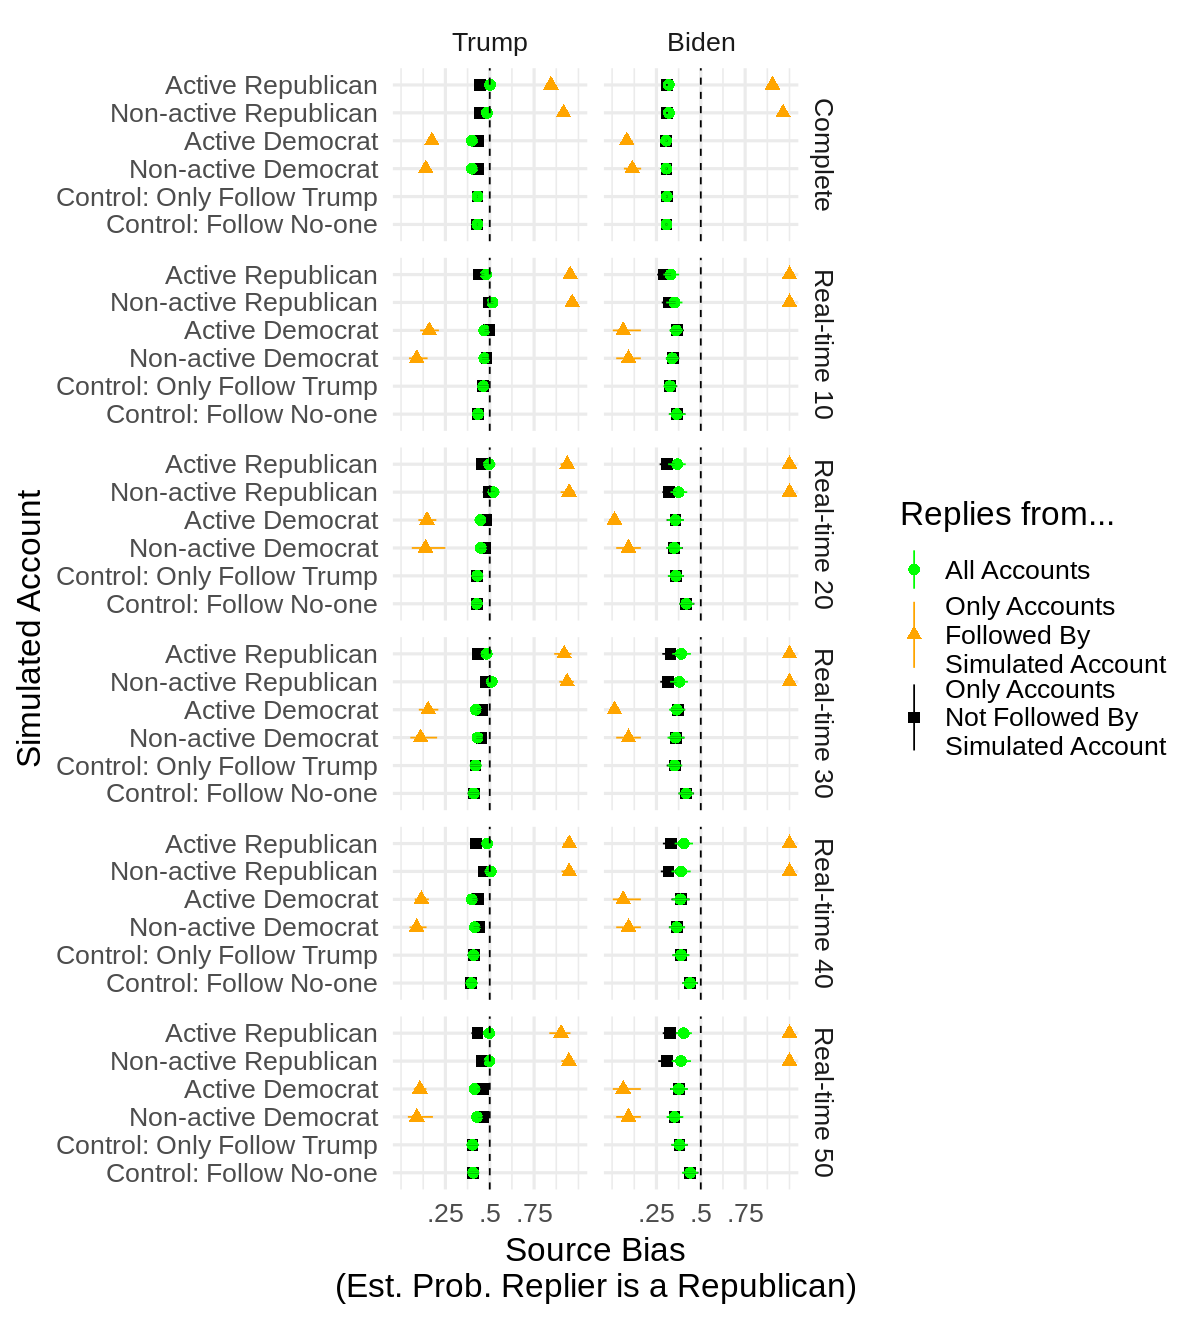

In [738]:
sourcebias_plt <- gen_bias_plot(pl_source,.5) + 
                    scale_y_continuous("Source Bias\n(Est. Prob. Replier is a Republican)",
                                         breaks=c(.25,.5,.75), labels=c(".25",".5",".75")) 
ggsave("sourcebias.pdf",sourcebias_plt,h=11,w=10)
pltsize(10,11)
#sourcebias_plt

# Content Bias

In [631]:
get_contentbias_data <- function(f){
    m <- fread(f)
    m$sentby <- NULL
    m$model_outputs_0 <- NULL
    m$preds <- NULL
    m$lang <- NULL
    setnames(m, "model_outputs_1","odds_rep")
    return(m)
}

content <- rbind(get_contentbias_data("trump_replies_preds.csv"),
                 get_contentbias_data("trump_real_time_preds.csv"),
                 get_contentbias_data("biden_real_time_preds.csv"),
                 get_contentbias_data("biden_replies_preds.csv"))

Warning message in set(x, j = name, value = value):
“Column 'sentby' does not exist to remove”Warning message in set(x, j = name, value = value):
“Column 'sentby' does not exist to remove”Warning message in set(x, j = name, value = value):
“Column 'sentby' does not exist to remove”

In [632]:
content_mg <- merge(reply_data,content, by.x="reply_tid", by.y="id")

In [633]:
content_bias <- create_bias_df(content_mg)

In [634]:
kv_content <- content_bias[!is.na(odds_rep), list(v= mean(odds_rep)), by=.(clean_acct,tid,t,sentby,sample)]
pl_content <- kv_content[, as.list(smean.cl.boot(v)),by=.(clean_acct,t,sentby,sample)]

In [635]:
pl_content$sentby <- factor(pl_content$sentby, levels=c("Trump","Biden"))

In [763]:
theme_set(theme_minimal(20))
pz <- ggplot(pl_content[sample != "Real-time 0"], 
             aes(clean_acct, Mean, ymin=Lower,ymax=Upper,color=t,shape=t))+
    geom_point(size=3) + geom_linerange() + coord_flip() +
    scale_color_manual("Replies from...", values=c("Green","Orange","Black")) + 
    scale_shape_discrete("Replies from...") +
    xlab("Simulated Account") +
    scale_y_continuous("Content Bias\n(Est. Prob. Reply was Sent by Republican)",
                                         breaks=c(.25,.5,.75), labels=c(".25",".5",".75")) +
    guides(color=guide_legend(keyheigh=.4, default.unit="in")) +
    facet_grid(sample~sentby) + geom_hline(yintercept =0.5, color = 'black', linetype='dashed')
ggsave("contentbias.pdf",pz,h=11,w=10)

pltsize(10,11)
#pz

# Combined

In [704]:
pl_content$biastype <- "Content Bias"
pl_source$biastype <- "Source Bias"
d <- rbind(pl_content, pl_source)

In [762]:
theme_set(theme_bw(16))

d$sentby <- factor(d$sentby, levels=c("Trump","Biden"))
#d <- d[sample %in% ]
d$sample <- factor(d$sample, levels=c("Real-time 10",
                                      "Real-time 20",
                                      "Real-time 30",
                                      "Real-time 40",
                                      "Real-time 50",
                                      "Complete"))
pz <- ggplot(d[t == "All Accounts" & !is.na(sample) & 
               sample %in% c("Complete", "Real-time 10",  "Real-time 50")],
             aes(clean_acct, Mean, ymin=Lower,ymax=Upper))+
    geom_point(size=3) + geom_linerange() + coord_flip() +
    xlab("Simulated Account") + 
    scale_y_continuous("Estimated Probability of Being Republican (On All Replies Seen)",
                       labels=function(x) sprintf("%.2f", x),
                       breaks = trans_breaks(identity, identity, n = 3)) + 
    guides(color=guide_legend(keyheigh=.4, default.unit="in")) +
    facet_wrap(sample~sentby+biastype,scales="free_x",ncol=4) 
ggsave("biasmeasures_all.pdf", w=10,h=9)
pltsize(10,9)
#pz

In [761]:
pz <- ggplot(d[#t != "Only Accounts\nFollowed By\nSimulated Account" & 
               !is.na(sample) & sample == "Complete" & sentby=="Trump"],
             aes(clean_acct, Mean, ymin=Lower,ymax=Upper))+
    geom_point(size=3) + geom_linerange() + coord_flip() +
    xlab("Simulated Account") + 
    scale_y_continuous("Estimated Probability of Being Republican (On All Replies Seen)",
                       labels=function(x) sprintf("%.2f", x)) + 
    guides(color=guide_legend(keyheigh=.4, default.unit="in")) +
    facet_grid(t~biastype,scales="free_x") 
ggsave("biasmeasures_complete.pdf", w=7,h=4.5)
pltsize(7,4.5)
#pz

In [760]:
d[#t != "Only Accounts\nFollowed By\nSimulated Account" & 
               !is.na(sample) & sample == "Complete" & sentby=="Trump"]

clean_acct,t,sentby,sample,Mean,Lower,Upper,biastype
Non-active Republican,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.4984538,0.4952742,0.5018288,Content Bias
Active Republican,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.5033629,0.4999461,0.5069763,Content Bias
Control: Only Follow Trump,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.4834150,0.4804472,0.4864330,Content Bias
Control: Follow No-one,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.4848402,0.4817690,0.4878736,Content Bias
Non-active Democrat,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.4771112,0.4738731,0.4804096,Content Bias
Active Democrat,Only Accounts Not Followed By Simulated Account,Trump,Complete,0.5000879,0.4966841,0.5036092,Content Bias
Active Democrat,Only Accounts Followed By Simulated Account,Trump,Complete,0.2583021,0.2527377,0.2639309,Content Bias
Active Republican,Only Accounts Followed By Simulated Account,Trump,Complete,0.6811257,0.6735093,0.6890194,Content Bias
Non-active Democrat,Only Accounts Followed By Simulated Account,Trump,Complete,0.2541148,0.2484586,0.2604608,Content Bias
Non-active Republican,Only Accounts Followed By Simulated Account,Trump,Complete,0.7615023,0.7529026,0.7706004,Content Bias


In [552]:
summary(lm(v~clean_acct,data=kv_content[sentby=="Trump"]))
summary(lm(v~clean_acct,data=kv_content[sentby=="Biden"]))


Call:
lm(formula = v ~ clean_acct, data = kv_content[sentby == "Trump"])

Residuals:
    Min      1Q  Median      3Q     Max 
-0.5402 -0.1266 -0.0067  0.1171  0.5702 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.4788695  0.0013574 352.778   <2e-16 ***
clean_acctControl: Only Follow Trump  0.0009055  0.0019177   0.472    0.637    
clean_acctNon-active Democrat        -0.0538533  0.0018017 -29.891   <2e-16 ***
clean_acctActive Democrat            -0.0425213  0.0018416 -23.090   <2e-16 ***
clean_acctNon-active Republican       0.0684974  0.0018394  37.239   <2e-16 ***
clean_acctActive Republican           0.0698318  0.0018103  38.575   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1886 on 134874 degrees of freedom
Multiple R-squared:  0.06564,	Adjusted R-squared:  0.06561 
F-statistic:  1895 on 5 and 134874 DF,  p-value: < 2.2e-16



Call:
lm(formula = v ~ clean_acct, data = kv_content[sentby == "Biden"])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.37540 -0.12269 -0.00769  0.11455  0.64168 

Coefficients:
                                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           0.366512   0.002315 158.296  < 2e-16 ***
clean_acctControl: Only Follow Trump -0.002236   0.003274  -0.683  0.49467    
clean_acctNon-active Democrat        -0.010389   0.003260  -3.187  0.00144 ** 
clean_acctActive Democrat            -0.009970   0.003252  -3.066  0.00217 ** 
clean_acctNon-active Republican       0.002644   0.003217   0.822  0.41113    
clean_acctActive Republican           0.012889   0.003210   4.016 5.94e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1802 on 37566 degrees of freedom
Multiple R-squared:  0.001975,	Adjusted R-squared:  0.001842 
F-statistic: 14.87 on 5 and 37566 DF,  p-value: 1.323e-14


In [ ]:
t.test(kv_source[sentby=="Biden" & clean_acct == "Active Democrat"]$v,
      kv_source[sentby=="Biden" & clean_acct == "Active Republican"]$v)

In [564]:
t.test(kv_content[sentby=="Biden" & clean_acct == "Active Democrat" & sample == "Complete" & t=="All Accounts"]$v,
      kv_content[sentby=="Biden" & clean_acct == "Non-active Republican"& sample == "Complete"& t=="All Accounts"]$v)


	Welch Two Sample t-test

data:  kv_content[sentby == "Biden" & clean_acct == "Active Democrat" &  and kv_content[sentby == "Biden" & clean_acct == "Non-active Republican" &     sample == "Complete" & t == "All Accounts"]$v and     sample == "Complete" & t == "All Accounts"]$v
t = -0.84277, df = 5101.8, p-value = 0.3994
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.012577576  0.005014761
sample estimates:
mean of x mean of y 
0.3682573 0.3720387 


In [553]:
summary(lm(v~clean_acct,data=kv_source[sentby=="Trump"]))
summary(lm(v~clean_acct,data=kv_source[sentby=="Biden"]))


Call:
lm(formula = v ~ clean_acct, data = kv_source[sentby == "Trump"])

Residuals:
     Min       1Q   Median       3Q      Max 
-0.46773 -0.02227 -0.00230  0.01833  0.57160 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           4.756e-03  2.487e-04  19.125   <2e-16 ***
clean_acctControl: Only Follow Trump -1.559e-05  3.514e-04  -0.044    0.965    
clean_acctNon-active Democrat        -6.721e-03  3.302e-04 -20.352   <2e-16 ***
clean_acctActive Democrat            -6.530e-03  3.375e-04 -19.347   <2e-16 ***
clean_acctNon-active Republican       5.822e-03  3.372e-04  17.267   <2e-16 ***
clean_acctActive Republican           5.149e-03  3.319e-04  15.515   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03455 on 134662 degrees of freedom
Multiple R-squared:  0.02149,	Adjusted R-squared:  0.02145 
F-statistic: 591.5 on 5 and 134662 DF,  p-value: < 2.2e-16


Call:
lm(formula = v ~ clean_acct, data = kv_source[sentby == "Biden"])

Residuals:
      Min        1Q    Median        3Q       Max 
-0.227830 -0.024298 -0.001576  0.021677  0.280830 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                          -0.0292346  0.0005114 -57.161  < 2e-16 ***
clean_acctControl: Only Follow Trump -0.0020832  0.0007232  -2.881 0.003970 ** 
clean_acctNon-active Democrat        -0.0027571  0.0007203  -3.828 0.000130 ***
clean_acctActive Democrat            -0.0010199  0.0007186  -1.419 0.155797    
clean_acctNon-active Republican       0.0024545  0.0007106   3.454 0.000552 ***
clean_acctActive Republican           0.0024785  0.0007098   3.492 0.000480 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.03979 on 37509 degrees of freedom
Multiple R-squared:  0.002662,	Adjusted R-squared:  0.002529 
F-statistic: 20.02 on 5 and 37509 DF,  p-value: